# Multi-class classification based on Softmax and Cross-Entropy using pytorch

## import libraries

In [1285]:
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.datasets import load_digits
from sklearn import datasets, model_selection
import pandas as pd
import numpy as np
from tqdm import tqdm
from matplotlib import pyplot as plt
from matplotlib import cm
import os
%matplotlib inline 

## load data

In [1286]:
#directory_data  = './data/'
filename_data   = 'assignment_06_data.npz'
data            = np.load(os.path.join(filename_data))

x_train = data['x_train']
y_train = data['y_train']

x_test  = data['x_test']
y_test  = data['y_test']

num_data_train  = x_train.shape[0]
num_data_test   = x_test.shape[0]

print('*************************************************')
print('size of x_train :', x_train.shape)
print('size of y_train :', y_train.shape)
print('*************************************************')
print('size of x_test :', x_test.shape)
print('size of y_test :', y_test.shape)
print('*************************************************')
print('number of training image :', x_train.shape[0])
print('height of training image :', x_train.shape[1])
print('width of training image :', x_train.shape[2])
print('*************************************************')
print('number of testing image :', x_test.shape[0])
print('height of testing image :', x_test.shape[1])
print('width of testing image :', x_test.shape[2])
print('*************************************************')

*************************************************
size of x_train : (20000, 32, 32)
size of y_train : (20000,)
*************************************************
size of x_test : (8000, 32, 32)
size of y_test : (8000,)
*************************************************
number of training image : 20000
height of training image : 32
width of training image : 32
*************************************************
number of testing image : 8000
height of testing image : 32
width of testing image : 32
*************************************************


## number of classes

In [1287]:
print('*************************************************')
print('number of classes :', len(set(y_train)))
print('*************************************************')
x_train = x_train.reshape(20000, 1024)
x_test = x_test.reshape(8000,1024)
pd.DataFrame(x_train)

*************************************************
number of classes : 10
*************************************************


,0,1,2,3,4,5,6,7,8,9,...,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
19996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
19997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
19998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0


## hyper-parameters

In [1288]:
number_epoch    = 1000
size_minibatch  = 10
learning_rate   = 0.01
weight_decay    = 1e-2

## custom data loader for the PyTorch framework

In [1289]:
y_train = y_train.astype(int)
y_test = y_test.astype(int)
# 훈련데이터 텐서 변환
x_train = torch.from_numpy(x_train).float()
y_train = torch.from_numpy(y_train).long()

# 테스트데이터 텐서 변환
x_test = torch.from_numpy(x_test).float()
y_test = torch.from_numpy(y_test).long()

# 변환된 텐서의 데이터 건수 확인
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)
# 설명변수와 목적변수 텐서를 합침
train = TensorDataset(x_train,y_train)
test = TensorDataset(x_test, y_test)
# 텐서의 첫 번째 데이터를 확인
print(train[0])

# 미니배치 분할
train_loader = DataLoader(train, batch_size= 10, shuffle= True)
test_loader= DataLoader(test, batch_size = 10, shuffle = True)

torch.Size([20000, 1024]) torch.Size([20000])
torch.Size([8000, 1024]) torch.Size([8000])
(tensor([0., 0., 0.,  ..., 0., 0., 0.]), tensor(0))


## shape of the data when using the data loader

In [1290]:
loss_mean_train     = np.zeros(number_epoch)
loss_std_train      = np.zeros(number_epoch)
accuracy_mean_train = np.zeros(number_epoch)
accuracy_std_train  = np.zeros(number_epoch)

loss_mean_test      = np.zeros(number_epoch)
loss_std_test       = np.zeros(number_epoch)
accuracy_mean_test  = np.zeros(number_epoch)
accuracy_std_test   = np.zeros(number_epoch)

## class for the neural network 

In [1291]:
# 모형 설계
class Net(nn.Module) : 
    
    def __init__(self):
        super(Net, self).__init__()
        
        #입력층
        self.fc1 = nn.Linear(1024,256)
        #중간층
        self.fc2 = nn.Linear(256,256)
        self.fc3 = nn.Linear(256,256)
        self.fc4 = nn.Linear(256,128)
        self.fc5 = nn.Linear(128,128)
        
        #출력층
        self.fc6 = nn.Linear(128,10)
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = F.relu(self.fc5(x))
        x = F.dropout(x, training=self.training)
        x = self.fc6(x)
        return F.log_softmax(x,dim =1)

# 인스턴스 생성
model =Net()

## build network

In [ ]:
%%time
# 오차함수 객체
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr = 0.01)

# 학습시작
for epoch in tqdm(range(1000)):
    total_loss = 0
    loss_train_epoch        = []
    accuracy_train_epoch    = []
    for train_x, train_y in train_loader:
        
        # 계산 그래프 구성
        train_x, train_y = torch.autograd.Variable(train_x), torch.autograd.Variable(train_y)
        
        # 경사 초기화
        optimizer.zero_grad()
        
        # 순전파 계산
        output = model.forward(train_x)
        
        # 오차 계산
        loss = criterion(output,train_y)
        predicted_classes = torch.argmax(output, 1) 
        correct_count = (predicted_classes == train_y) # 맞는 개수의 평균을 내면 정확도가 나옴. 
        accuracy = correct_count.float().mean()
        # 역전파 계산
        loss.backward()

        # 가중치 업데이트
        optimizer.step()
        loss_train_epoch.append(loss.item())
        accuracy_train_epoch.append(accuracy.item())
    loss_mean_train[epoch]      = np.mean(loss_train_epoch)
    loss_std_train[epoch]       = np.std(loss_train_epoch)

    accuracy_mean_train[epoch]  = np.mean(accuracy_train_epoch)
    accuracy_std_train[epoch]   = np.std(accuracy_train_epoch)  
    
    loss_test_epoch        = []
    accuracy_test_epoch    = []
    for test_x, test_y in test_loader:
        
        # 계산 그래프 구성
        test_x, test_y = torch.autograd.Variable(test_x), torch.autograd.Variable(test_y)
        output_test = model.forward(test_x)
        
        loss_test = criterion(output_test,test_y)
        predicted_classes_test = torch.argmax(output_test, 1) 
        correct_count_test = (predicted_classes_test == test_y) # 맞는 개수의 평균을 내면 정확도가 나옴. 
        accuracy_test = correct_count_test.float().mean()
        loss_test_epoch.append(loss_test.item())
        accuracy_test_epoch.append(accuracy_test.item())
    loss_mean_test[epoch]      = np.mean(loss_test_epoch)
    loss_std_test[epoch]       = np.std(loss_test_epoch)
    
    accuracy_mean_test[epoch]  = np.mean(accuracy_test_epoch)
    accuracy_std_test[epoch]   = np.std(accuracy_test_epoch)

  0%|                                                                               | 1/1000 [00:07<2:00:50,  7.26s/it]

## plot curve

In [1297]:
def plot_curve_error(data_mean, data_std, x_label, y_label, title):

    plt.figure(figsize=(8, 6))
    plt.title(title)

    alpha = 0.3
    
    plt.plot(range(len(data_mean)), data_mean, '-', color = 'red')
    plt.fill_between(range(len(data_mean)), data_mean - data_std, data_mean + data_std, facecolor = 'blue', alpha = alpha) 
    
    plt.xlabel(x_label)
    plt.ylabel(y_label)

    plt.tight_layout()
    plt.show()

In [1298]:
def print_curve(data, index):
    
    for i in range(len(index)):

        idx = index[i]
        val = data[idx]

        print('index = %2d, value = %12.10f' % (idx, val))

In [1299]:
def get_data_last(data, index_start):

    data_last = data[index_start:]

    return data_last

In [1300]:
def get_max_last_range(data, index_start):

    data_range = get_data_last(data, index_start)
    value = data_range.max()

    return value

In [1301]:
def get_min_last_range(data, index_start):

    data_range = get_data_last(data, index_start)
    value = data_range.min()

    return value

---

# functions for presenting the results

---

In [1302]:
def function_result_01():

    plot_curve_error(loss_mean_train, loss_std_train, 'epoch', 'loss', 'loss (training)')

In [1303]:
def function_result_02():

    plot_curve_error(accuracy_mean_train, accuracy_std_train, 'epoch', 'accuracy', 'accuracy (training)')

In [1304]:
def function_result_03():
    
    plot_curve_error(loss_mean_test, loss_std_test, 'epoch', 'loss', 'loss (testing)')

In [1305]:
def function_result_04():
    
    plot_curve_error(accuracy_mean_test, accuracy_std_test, 'epoch', 'accuracy', 'accuracy (testing)')

In [1306]:
def function_result_05():
    
    data_last = get_data_last(loss_mean_train, -10)
    index = np.arange(0, 10)
    print_curve(data_last, index)

In [1307]:
def function_result_06():
    
    data_last = get_data_last(accuracy_mean_train, -10)
    index = np.arange(0, 10)
    print_curve(data_last, index)

In [1308]:
def function_result_07():
    
    data_last = get_data_last(loss_mean_test, -10)
    index = np.arange(0, 10)
    print_curve(data_last, index)

In [1309]:
def function_result_08():
    
    data_last = get_data_last(accuracy_mean_test, -10)
    index = np.arange(0, 10)
    print_curve(data_last, index)

In [1310]:
def function_result_09():
    
    value = get_max_last_range(accuracy_mean_train, -10)
    print('best training accuracy = %12.10f' % (value))

In [1311]:
def function_result_10():
    
    value = get_max_last_range(accuracy_mean_test, -10)
    print('best testing accuracy = %12.10f' % (value))

---

# RESULTS

---

## # 01. plot the training loss curve (mean, std)

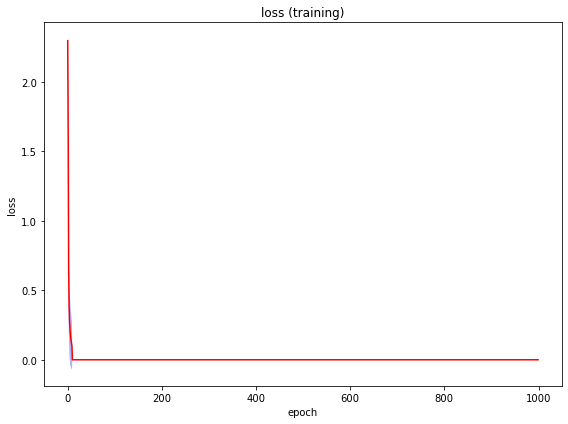

In [1312]:
function_result_01()

## # 02. plot the training accuracy curve (mean, std)

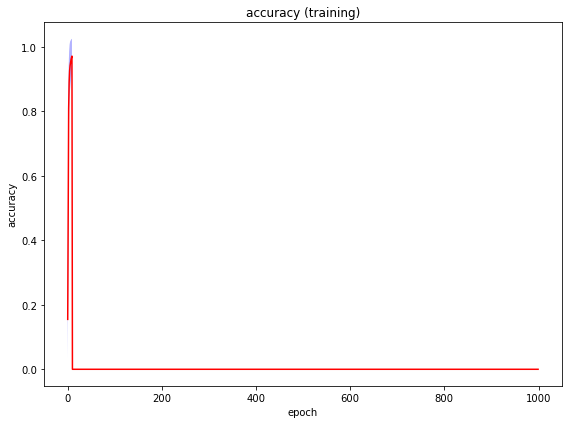

In [1313]:
function_result_02()

## # 03. plot the testing loss curve (mean, std)

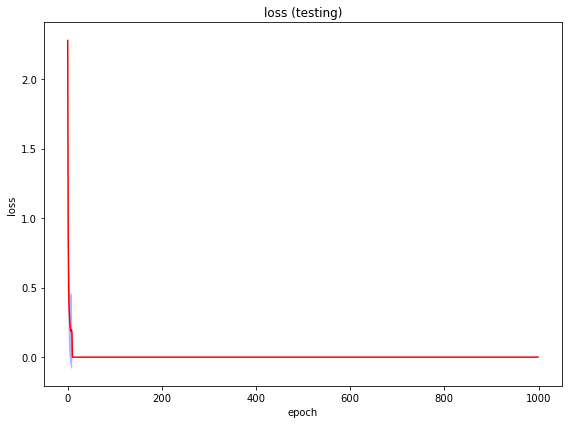

In [1314]:
function_result_03()

## # 04. plot the testing accuracy curve (mean, std)

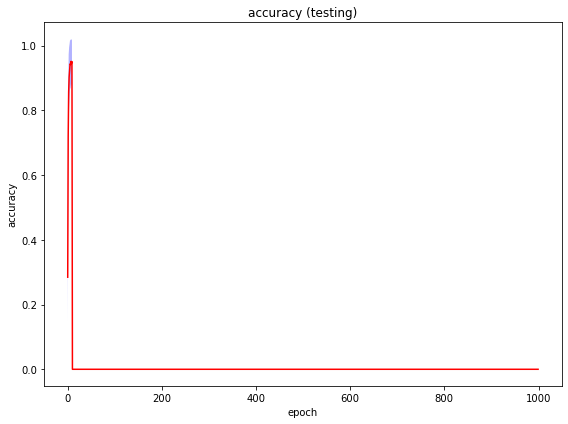

In [1315]:
function_result_04()

## # 05. print the training (mean) loss over batches at last 10 epochs

In [1117]:
function_result_05()

index =  0, value = 2.3047280514
index =  1, value = 2.3048352373
index =  2, value = 2.3048086727
index =  3, value = 2.3049140584
index =  4, value = 2.3045334625
index =  5, value = 2.3048085415
index =  6, value = 2.3046420240
index =  7, value = 2.3048294353
index =  8, value = 2.3048701096
index =  9, value = 2.3047512615


## # 06. print the training (mean) accuracy over batches at last 10 epochs

In [1118]:
function_result_06()

index =  0, value = 0.0979499974
index =  1, value = 0.0950999974
index =  2, value = 0.1002999973
index =  3, value = 0.0950999973
index =  4, value = 0.0989999972
index =  5, value = 0.0978499972
index =  6, value = 0.0971499975
index =  7, value = 0.0990499973
index =  8, value = 0.0972499972
index =  9, value = 0.0957999976


## # 07. print the testing (mean) loss over batches at last 10 epochs

In [1119]:
function_result_07()

index =  0, value = 2.3038569927
index =  1, value = 2.3038569778
index =  2, value = 2.3038569868
index =  3, value = 2.3038569480
index =  4, value = 2.3038569599
index =  5, value = 2.3038569719
index =  6, value = 2.3038569659
index =  7, value = 2.3038569778
index =  8, value = 2.3038569599
index =  9, value = 2.3038569599


## # 08. print the testing (mean) accuracy over batches at last 10 epochs

In [999]:
function_result_08()

index =  0, value = 0.0899999961
index =  1, value = 0.0899999961
index =  2, value = 0.0899999961
index =  3, value = 0.0899999961
index =  4, value = 0.1099999994
index =  5, value = 0.1199999973
index =  6, value = 0.1299999952
index =  7, value = 0.1099999994
index =  8, value = 0.1099999994
index =  9, value = 0.1099999994


## # 09. print the best training (mean) accuracy within the last 10 epochs

In [925]:
function_result_09()

best training accuracy = 0.1023999973


## # 10. print the best testing (mean) accuracy within the last 10 epochs

In [926]:
function_result_10()

best testing accuracy = 0.2800000012
